# Clinical dataset

The data contains 89 non-small cell lung cancer patients that were treated with surgery. The authors used it to investigate the association of radiomic imaging features with gene-expression profiles.

"Radiogenomics analysis revealed that a prognostic radiomic signature, capturing intra-tumour heterogeneity, was associated with underlying gene-expression patterns." [1] Thus, we can separate signatures based on underlying gene-expression patterns.

The samples were obtained through biopsies at MAASTRO Clinic, The Netherlands. The dataset is available on [2].


**Goal**: use unsupervised learning to develop an accurate ML model that can distinguish the histology.
- The two datasets have to be combined.

Datasets:
- Lung metadata dataset [1]
- Gene expression dataset

**Questions**:
- Is this data single-cell data or is this the 'average' of all cells?



[1] https://wiki.cancerimagingarchive.net/display/Public/NSCLC-Radiomics-Genomics#16056856db10d39adf704eefa53e41edcf5ef41c

[2] https://ftp.ncbi.nlm.nih.gov/geo/series/GSE58nnn/GSE58661/matrix/

# Imports

In [1]:
import gzip

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Datasets

## Lung metadata
The data consists of 89 samples. It describes the characteristics of the patient, tumour and tested molecule.

In [2]:
meta_data = pd.read_excel('data/Lung3.metadata.xls')
meta_data.head()

,sample.name,title,CEL.file,source.location,organism,characteristics.tag.gender,characteristics.tag.histology,characteristics.tag.tumor.size.maximumdiameter,characteristics.tag.stage.primary.tumor,characteristics.tag.stage.nodes,characteristics.tag.stage.mets,characteristics.tag.primaryVSmets,characteristics.tag.grade,molecule tested,label,platform
0,LUNG3-01,lung_1,LUNG3-01.CEL,Left Lower Lobe,Homo sapiens,M,"Squamous Cell Carcinoma, NOS",4.0,pT2,pN0,pM0,Primary,3,total RNA,biotin,GPL15048
1,LUNG3-02,lung_2,LUNG3-02.CEL,Left Lower Lobe,Homo sapiens,M,"Adenocarcinoma, Papillary, NOS",1.3,pT1,pNX,pMX,Primary,Not Available,total RNA,biotin,GPL15048
2,LUNG3-03,lung_3,LUNG3-03.CEL,Left Lower Lobe,Homo sapiens,M,Non-Small Cell,11.0,pT3,pN0,pM0,Primary,3,total RNA,biotin,GPL15048
3,LUNG3-04,lung_4,LUNG3-04.CEL,Left Lower Lobe,Homo sapiens,M,"Papillary Type AND Adenocarcinoma, Bronch...",NaN,pTX,pNx,pM1,Primary,Not Available,total RNA,biotin,GPL15048
4,LUNG3-05,lung_5,LUNG3-05.CEL,Left Lower Lobe,Homo sapiens,F,"Squamous Cell Carcinoma, NOS",7.8,pT3,pN0,pM0,Primary,2,total RNA,biotin,GPL15048


In [3]:
meta_data.tail()

,sample.name,title,CEL.file,source.location,organism,characteristics.tag.gender,characteristics.tag.histology,characteristics.tag.tumor.size.maximumdiameter,characteristics.tag.stage.primary.tumor,characteristics.tag.stage.nodes,characteristics.tag.stage.mets,characteristics.tag.primaryVSmets,characteristics.tag.grade,molecule tested,label,platform
84,LUNG3-85,lung_85,LUNG3-85.CEL,Right Upper Lobe,Homo sapiens,M,"Adenocarcinoma, Acinar Type",2.2,pT1b,pN0,pM0,Primary,Not Available,total RNA,biotin,GPL15048
85,LUNG3-86,lung_86,LUNG3-86.CEL,Right Upper Lobe,Homo sapiens,M,"Squamous Cell Carcinoma, NOS",5.0,pT3,PN2,pM0,Primary,3,total RNA,biotin,GPL15048
86,LUNG3-87,lung_87,LUNG3-87.CEL,Right Middle Lobe,Homo sapiens,M,"Squamous Cell Carcinoma, Papillary",3.5,pT2,pN0,pM0,Primary,2,total RNA,biotin,GPL15048
87,LUNG3-88,lung_88,LUNG3-88.CEL,Right Upper Lobe,Homo sapiens,M,"Non-Small Cell, Pleomorphic Type",8.5,pT3,pN0,pM0,Primary,Not Available,total RNA,biotin,GPL15048
88,LUNG3-89,lung_89,LUNG3-89.CEL,Left Upper Lobe,Homo sapiens,F,"Squamous Cell Carcinoma, NOS",3.5,pT2,pN1,pM0,Primary,1,total RNA,biotin,GPL15048


In [4]:
meta_data.columns

Index(['sample.name', 'title', 'CEL.file', 'source.location', 'organism',
       'characteristics.tag.gender', 'characteristics.tag.histology',
       'characteristics.tag.tumor.size.maximumdiameter',
       'characteristics.tag.stage.primary.tumor',
       'characteristics.tag.stage.nodes', 'characteristics.tag.stage.mets',
       'characteristics.tag.primaryVSmets', 'characteristics.tag.grade',
       'molecule tested', 'label', 'platform'],
      dtype='object')

We are interested signatures, therefore we make a collections of columns to keep. These are the *characteristics* of the patient and tumour, and the identifier.

In [5]:
to_keep = ['sample.name', 'source.location', 'characteristics.tag.gender', 
           'characteristics.tag.histology',
           'characteristics.tag.tumor.size.maximumdiameter',
           'characteristics.tag.stage.primary.tumor',
           'characteristics.tag.stage.nodes', 'characteristics.tag.stage.mets',
           'characteristics.tag.primaryVSmets', 'characteristics.tag.grade']
meta = meta_data[to_keep]
meta.head()

,sample.name,source.location,characteristics.tag.gender,characteristics.tag.histology,characteristics.tag.tumor.size.maximumdiameter,characteristics.tag.stage.primary.tumor,characteristics.tag.stage.nodes,characteristics.tag.stage.mets,characteristics.tag.primaryVSmets,characteristics.tag.grade
0,LUNG3-01,Left Lower Lobe,M,"Squamous Cell Carcinoma, NOS",4.0,pT2,pN0,pM0,Primary,3
1,LUNG3-02,Left Lower Lobe,M,"Adenocarcinoma, Papillary, NOS",1.3,pT1,pNX,pMX,Primary,Not Available
2,LUNG3-03,Left Lower Lobe,M,Non-Small Cell,11.0,pT3,pN0,pM0,Primary,3
3,LUNG3-04,Left Lower Lobe,M,"Papillary Type AND Adenocarcinoma, Bronch...",NaN,pTX,pNx,pM1,Primary,Not Available
4,LUNG3-05,Left Lower Lobe,F,"Squamous Cell Carcinoma, NOS",7.8,pT3,pN0,pM0,Primary,2


I'm not going to explore this dataset immediately. First need to know what the gene expression dataset looks like and how it can be combined.

## Gene expression data
After analyzing the file with the `gzip` package, and the `enumerate` function, I found that the matrix starts after line 61. Thus, the first 61 lines are the header.

In [6]:
header = ''
with gzip.open('data/GSE58661_series_matrix.txt.gz', 'rt') as f:
    for i, line in enumerate(f):
        header += line
        
        if i == 61:
            break

In [7]:
print(header)

!Series_title	"89 NSCLC patients with gene expression profiles and matching CT imaging data available at TCIA."
!Series_geo_accession	"GSE58661"
!Series_status	"Public on Jun 19 2014"
!Series_submission_date	"Jun 19 2014"
!Series_last_update_date	"Jun 05 2019"
!Series_pubmed_id	"24892406"
!Series_pubmed_id	"28731408"
!Series_summary	"The Lung3 data set consists of 89 NSCLC patients that were treated at MAASTRO Clinic, The Netherlands. For these patients pretreatment CT scans, tumour delineations and gene expression profiles were available. We used this data set to associate imaging features with gene-expression profiles."
!Series_overall_design	"89 samples from NSCLC patients. Samples were obtained by biopsies from cancerous tissue. Tumors were classified as Adenocarcinoma, Papillary, NOS; Squamous Cell Carcinoma, NOS; Non-Small Cell; Papillary Type; or Solid Type."
!Series_type	"Expression profiling by array"
!Series_contributor	"Hugo,J,Aerts"
!Series_contributor	"Patrick,,Grossmann"


Main takeaway from the header:
- 89 biopsy samples from cancerious tissue from NSCLC patients.
- Tumors were classified as: 
    - Adenocarcinoma
    - Papillary, NOS
    - Squamous Cell Carcinoma, NOS
    - Non-Small cell
    - Papillary Type
    - Solid Type
- Sample IDs are starting with `GSMXXXXXX`
- Sample title starts with lung_1 and ends with lung_89. This is the same as the Meta data. The same is true for the position (left lower lobe, right middle lobe, etc.) and other variables.
- Sample type is RNA

In [8]:
gene = pd.read_csv('data/GSE58661_series_matrix.txt.gz', compression='gzip', header=61, sep='\t')
gene.head(3)

,ID_REF,GSM1416528,GSM1416529,GSM1416530,GSM1416531,GSM1416532,GSM1416533,GSM1416534,GSM1416535,GSM1416536,...,GSM1416607,GSM1416608,GSM1416609,GSM1416610,GSM1416611,GSM1416612,GSM1416613,GSM1416614,GSM1416615,GSM1416616
0,AFFX-BioB-3_at,7.376915,8.024915,7.522543,7.152864,7.211031,7.704962,7.779374,7.136893,7.160221,...,7.611992,7.345206,7.316975,7.418340,7.756286,7.215856,7.465109,7.245458,7.039592,7.393667
1,AFFX-BioB-5_at,6.984530,7.427048,7.077207,6.849513,6.753131,7.195947,7.429800,6.745630,6.751358,...,7.175015,7.014479,6.913879,6.898449,7.347570,6.740992,7.080787,6.725812,6.575376,7.041106
2,AFFX-BioB-M_at,7.330576,8.010530,7.334551,7.143286,7.077163,7.753484,7.712429,7.036303,7.089186,...,7.612393,7.285821,7.324635,7.408880,7.745624,7.152722,7.422373,7.263596,6.975162,7.366620


In [9]:
gene.tail()

,ID_REF,GSM1416528,GSM1416529,GSM1416530,GSM1416531,GSM1416532,GSM1416533,GSM1416534,GSM1416535,GSM1416536,...,GSM1416607,GSM1416608,GSM1416609,GSM1416610,GSM1416611,GSM1416612,GSM1416613,GSM1416614,GSM1416615,GSM1416616
60603,merck2-Z70222_a_at,6.892053,5.513603,6.112918,6.276813,7.041829,7.560786,7.446324,7.821045,7.465401,...,7.028523,6.229570,7.543618,7.518894,6.541189,6.493021,7.952822,6.978308,7.460604,7.519374
60604,merck2-Z70608_x_at,1.777216,1.940099,1.753519,1.889742,1.686633,1.988420,1.723665,2.029634,1.986343,...,3.246869,1.910438,1.910438,2.054199,1.730252,1.924313,1.783032,1.371800,1.811532,2.444065
60605,merck2-Z72499_a_at,9.031084,9.527973,9.515653,9.383670,9.464486,9.558521,9.651009,9.479608,9.417764,...,9.349558,9.377011,9.379870,9.398441,9.269749,9.223950,9.481911,9.632680,9.313734,9.527973
60606,merck2-Z75331_a_at,7.284069,6.985508,6.556233,7.293852,6.244336,5.562862,6.933691,6.389961,6.860160,...,6.622611,6.406113,6.642260,6.292372,6.618915,5.817185,7.487134,7.410402,6.396247,5.605377
60607,!series_matrix_table_end,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# the last row should be removed
gene = gene.drop(gene.index[60607])

In [11]:
gene.shape

(60607, 90)

Sample IDs with GSM14XXXXX, therefore we need to transpose the dataframe. 

In [1]:
gene = gene.T
gene.head()

NameError: name 'gene' is not defined

In [13]:
# AFFX- should be the header column
# drop the ID_ref

gene, gene.columns = gene.iloc[1:], gene.iloc[0]
gene = gene.rename_axis(columns=None)

In [14]:
gene.head()

,AFFX-BioB-3_at,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioC-3_at,AFFX-BioC-5_at,AFFX-BioDn-3_at,AFFX-BioDn-5_at,AFFX-BkGr-GC03_at,AFFX-BkGr-GC04_at,AFFX-BkGr-GC05_at,...,merck2-Z41436_at,merck2-Z43503_at,merck2-Z47244_x_at,merck2-Z47250_x_at,merck2-Z48501_s_at,merck2-Z48633_s_at,merck2-Z70222_a_at,merck2-Z70608_x_at,merck2-Z72499_a_at,merck2-Z75331_a_at
GSM1416528,7.376915,6.98453,7.330576,10.922741,11.03203,13.411168,12.625445,1.464847,1.416673,1.438285,...,7.077955,4.350631,7.506299,9.774634,11.295187,10.286077,6.892053,1.777216,9.031084,7.284069
GSM1416529,8.024915,7.427048,8.01053,11.390638,11.533338,13.546671,12.898906,1.502126,1.398866,1.403564,...,7.552333,3.578359,5.51644,4.601167,11.443442,11.173715,5.513603,1.940099,9.527973,6.985508
GSM1416530,7.522543,7.077207,7.334551,10.936703,11.01851,13.360017,12.540647,1.355337,1.343599,1.306212,...,5.084856,2.937384,6.310065,6.315107,11.584115,10.58654,6.112918,1.753519,9.515653,6.556233
GSM1416531,7.152864,6.849513,7.143286,10.791909,10.875259,13.364171,12.579293,1.327548,1.272961,1.354529,...,7.136409,2.904756,5.954062,6.738276,11.2403,10.257621,6.276813,1.889742,9.38367,7.293852
GSM1416532,7.211031,6.753131,7.077163,10.701328,10.823792,13.340075,12.420624,1.296788,1.244117,1.291959,...,7.66715,3.119091,7.257312,8.118139,10.998377,10.634072,7.041829,1.686633,9.464486,6.244336


In [22]:
gene.shape

(89, 60607)

In [16]:
# some experimenting
gene.max().max()

14.78928073

In [17]:
gene.min().min()

1.018222123

There are 89 rows, which fit perfectly with the observations from the meta data.

We also have 60607 genes. This takes a lot of memory. However I'm not sure if we can just take a sample and expect that sample to be representative for the whole expression.

In [23]:
gene.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89 entries, GSM1416528 to GSM1416616
Columns: 60607 entries, AFFX-BioB-3_at to merck2-Z75331_a_at
dtypes: object(60607)
memory usage: 41.2+ MB


41.2+ MB of memory seems fine to continue with the full dataset. 

In [24]:
gene.dtypes.unique()

array([dtype('O')], dtype=object)

In [25]:
# we want float numbers
gene = gene.astype(float)

Lets take a look if the correlation differs if we take different samples. This would indicate that a sample would not be representative for the whole gene expression matrix.

In [26]:
plot_sample_base = gene.sample(5000, axis='columns').copy()

plot_sample_base_1 = plot_sample_base.sample(50, axis='columns')
plot_sample_base_2 = plot_sample_base.sample(50, axis='columns')

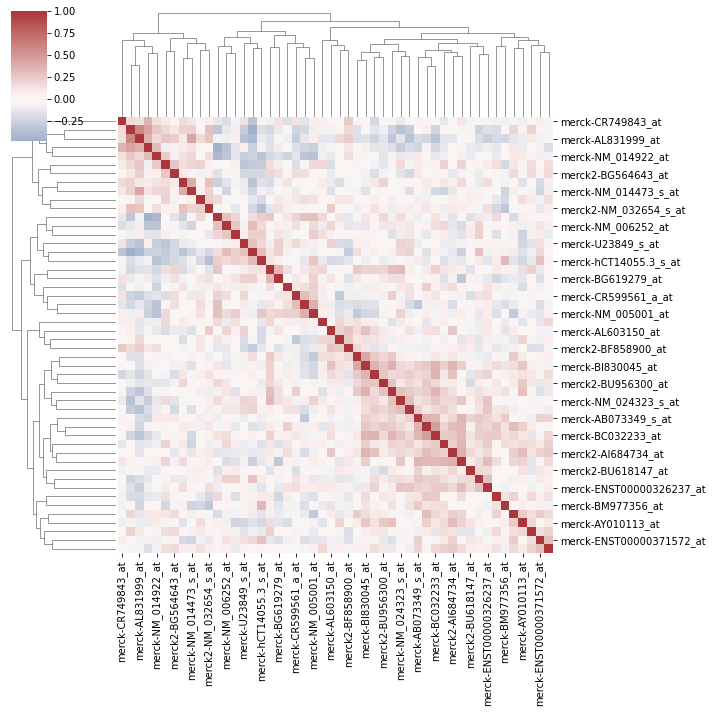

In [42]:
sns.clustermap(plot_sample_base_1.corr(), center=0, cmap='vlag', figsize=(10, 10))

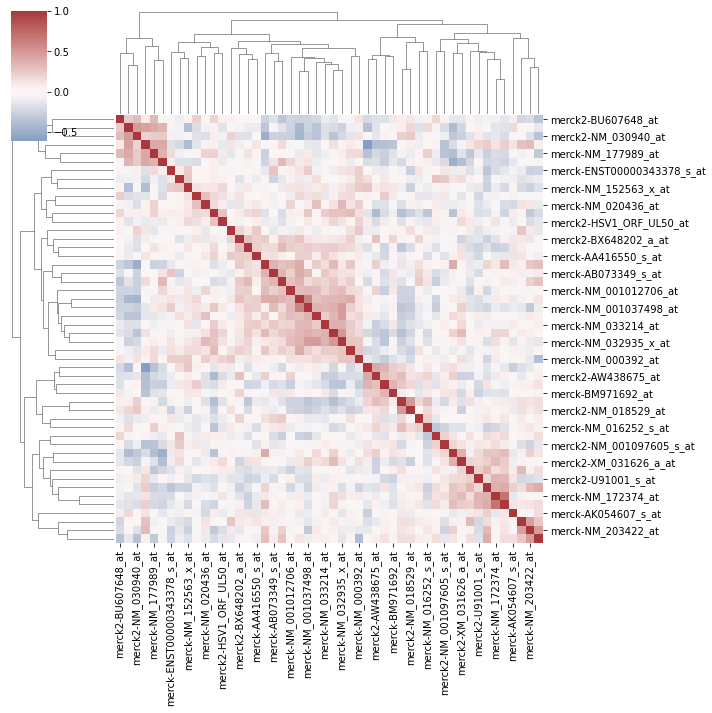

In [28]:
sns.clustermap(plot_sample_base_2.corr(), center=0, cmap='vlag', figsize=(10, 10))

(array([ 3.,  1.,  4.,  8., 20., 11., 22.,  9.,  7.,  4.]),
 array([4.24275618, 4.3794602 , 4.51616422, 4.65286824, 4.78957226,
        4.92627628, 5.0629803 , 5.19968432, 5.33638833, 5.47309235,
        5.60979637]),
 <BarContainer object of 10 artists>)

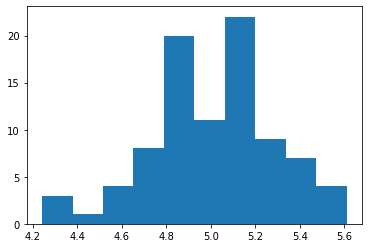

In [53]:
t = plot_sample_base_2[plot_sample_base_2.columns[40]]
plt.hist(t)

We can see that gene expression depends on the genes and that a sample is not generalizable for the whole set of genes. Specific parts are expressed in different ways. Therefore we will keep working with the whole gene expression set. In addition, they are all related to lung cancer and therefore it would be a good idea to analyze them as a whole. 

there are some highly correlated features. We can use statistical methods to remove extremely correlated genes.

----------

Unfortunately the dataset is too big to compute the correlation matrix. It is not able to load all data in memory. An option is to use parallel processing. However, I'll first skip this.

--------

<AxesSubplot:>

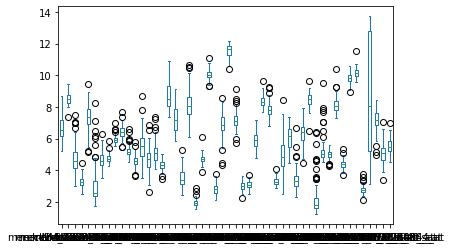

In [57]:
plot_sample_base_2.plot(kind='box')

In [31]:
# memory error ...............
# c = gene.corr()

# filtered = c[((c >= 0.8) | (c <= -0.8)) & (c != 1.0)]
# flattened = filtered.unstack().sort_values().drop_duplicates()
# to_remove = pd.DataFrame(flattened).reset_index()['level_1'].tolist()

The 2 datasets are in order based on the header. Therefore we can add them together.

In [44]:
meta

,sample.name,source.location,characteristics.tag.gender,characteristics.tag.histology,characteristics.tag.tumor.size.maximumdiameter,characteristics.tag.stage.primary.tumor,characteristics.tag.stage.nodes,characteristics.tag.stage.mets,characteristics.tag.primaryVSmets,characteristics.tag.grade
0,LUNG3-01,Left Lower Lobe,M,"Squamous Cell Carcinoma, NOS",4.0,pT2,pN0,pM0,Primary,3
1,LUNG3-02,Left Lower Lobe,M,"Adenocarcinoma, Papillary, NOS",1.3,pT1,pNX,pMX,Primary,Not Available
2,LUNG3-03,Left Lower Lobe,M,Non-Small Cell,11.0,pT3,pN0,pM0,Primary,3
3,LUNG3-04,Left Lower Lobe,M,"Papillary Type AND Adenocarcinoma, Bronch...",NaN,pTX,pNx,pM1,Primary,Not Available
4,LUNG3-05,Left Lower Lobe,F,"Squamous Cell Carcinoma, NOS",7.8,pT3,pN0,pM0,Primary,2
...,...,...,...,...,...,...,...,...,...,...
84,LUNG3-85,Right Upper Lobe,M,"Adenocarcinoma, Acinar Type",2.2,pT1b,pN0,pM0,Primary,Not Available
85,LUNG3-86,Right Upper Lobe,M,"Squamous Cell Carcinoma, NOS",5.0,pT3,PN2,pM0,Primary,3
86,LUNG3-87,Right Middle Lobe,M,"Squamous Cell Carcinoma, Papillary",3.5,pT2,pN0,pM0,Primary,2
87,LUNG3-88,Right Upper Lobe,M,"Non-Small Cell, Pleomorphic Type",8.5,pT3,pN0,pM0,Primary,Not Available


Describing the spread
- Useful to measure how variable values are. This can be done with variance and standard deviation. However, these are easily affected by outlier. A common way is to look at the difference between 75th percentile and 25th percentile, IQR.

Can also do hypothesis testing between samples. "Is there a difference between samples"

**Clustering**

"Do the patients with similar diseases have similar gene expression profiles?"
- Distance metric is very important. 
    - Manhattan distance / l1 norm
    - Euclidean distance. May be affected by outliers due to the squaring operation, which causes a higher contribution to distance.
    - Correlation distance. Vectors that have a similar pattern will have a small distance, whereas vectors with different patterns will have a large distance.
- scaling: is the data already scaled or not?
- Hierarchical clustering

Sometimes you can keep the most variable genes, since genes that are not very variable do not contribute much to the distances between patient. [4.1.2] Exploratory analysis of gene expression levels! Very interesting!

Multidimensional scaling could be interesting as well [4.1.3]

Data preprocessing [5.4]

In [56]:
variance = gene.var()
print(min(variance), max(variance))

0.00023128891633441545 19.131002790330307


In [78]:
test = gene.copy()
test['histology'] = meta['characteristics.tag.histology'].values
test = test.set_index('histology')
test = test.sample(50, axis=1)

In [79]:
test.head()

,merck-BX537746_a_at,merck-NM_001901_at,merck2-NM_018615_a_at,merck-hCT1642439.3_at,merck-NR_002908_x_at,merck-hCT2267953_at,merck-RSE_00000228387_at,merck2-NM_145114_at,merck-NM_001030287_s_at,merck-BC043554_s_at,...,merck2-T79866_at,merck-NM_021036_s_at,merck-NM_004278_at,merck2-AK222896_at,merck-BG287509_a_at,merck2-BX647862_at,merck-AK027759_a_at,merck-NM_020821_at,merck-BM987048_at,merck2-BG758758_at
histology,,,,,,,,,,,,,,,,,,,,,
"Squamous Cell Carcinoma, NOS",8.438459,11.972196,4.976738,2.236054,3.234880,3.469075,2.434678,6.321765,8.245600,3.755041,...,4.720105,7.790866,5.554926,8.085770,8.168792,8.535318,9.865400,9.898786,5.679431,5.651824
"Adenocarcinoma, Papillary, NOS",8.114453,10.853984,5.358033,2.074821,2.372841,4.270571,2.650307,5.423327,7.795816,4.858571,...,5.569452,7.963361,6.500454,6.517743,6.780535,8.304055,10.471641,10.603585,6.248430,6.134727
Non-Small Cell,9.148630,12.660826,5.762045,2.455124,2.803546,4.047404,2.624297,5.394842,8.141739,3.851604,...,5.296495,8.971477,6.504796,8.135515,7.169283,8.243825,9.898436,9.586982,5.907417,5.234123
"Papillary Type AND Adenocarcinoma, Bronchiolo-alveolar Features",8.185773,10.430675,6.887234,2.234124,2.438945,3.668239,2.438004,6.463072,6.971830,4.027898,...,5.006902,7.300300,6.873161,8.246285,8.216646,9.432698,9.816936,10.744943,5.485876,5.529097
"Squamous Cell Carcinoma, NOS",7.645143,10.792463,6.241059,2.087559,2.308809,3.805180,2.308244,6.037466,8.679486,4.655249,...,5.089504,7.012266,6.207889,8.727706,8.233629,9.031971,9.777726,9.951708,5.097127,6.618965


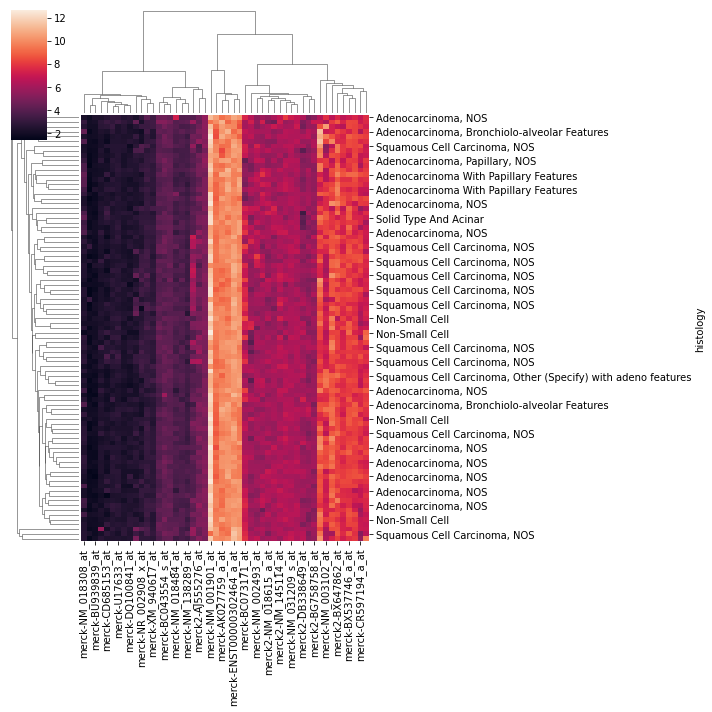

In [80]:
sns.clustermap(test)

In [81]:
penguins = sns.load_dataset('penguins').dropna()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [85]:
numerical_cols = penguins.columns[2:6]
species_colors = penguins.species.map({
    'Adelie': 'blue', 
    'Chinstrap': 'red',
    'Gentoo': 'green'
})

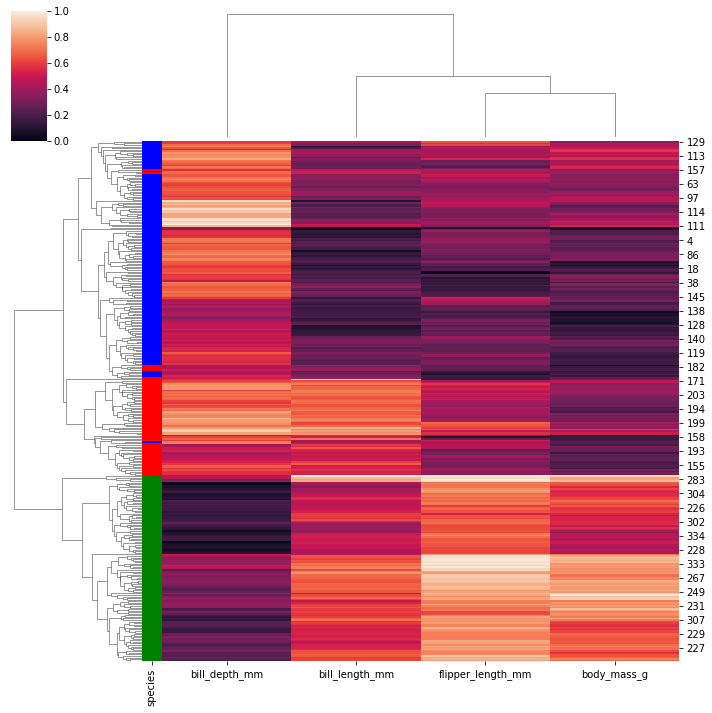

In [90]:
sns.clustermap(penguins[numerical_cols], standard_scale=1, row_colors=species_colors)

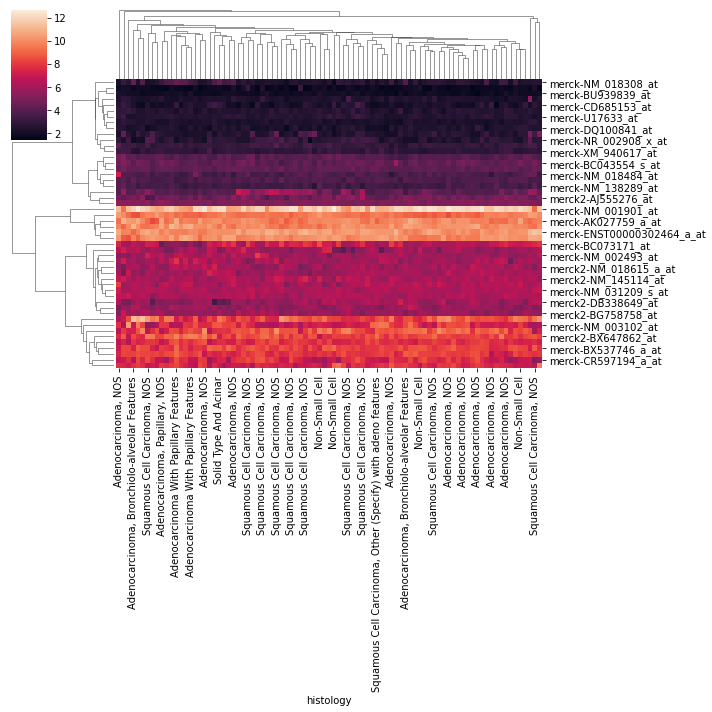

In [94]:
sns.clustermap(test.T)

In [95]:
def get_colors(df, name, color) -> pd.Series:
    s = df[name]
    su = s.unique()
    colors = sns.light_palette(color, len(su))
    lut = dict(zip(su, colors))
    return s.map(lut)

In [96]:
histology_color = get_colors(meta, 'characteristics.tag.histology', 'red')

In [98]:
histology_color

0     (0.9522635075378764, 0.9411073728435433, 0.940...
1     (0.9552587384374606, 0.8820574984690465, 0.881...
2     (0.9582539693370449, 0.8230076240945496, 0.822...
3     (0.9612492002366291, 0.7639577497200528, 0.763...
4     (0.9522635075378764, 0.9411073728435433, 0.940...
                            ...                        
84    (0.9762253547345502, 0.46870837784756864, 0.46...
85    (0.9522635075378764, 0.9411073728435433, 0.940...
86    (0.9971919710316398, 0.05535925722609081, 0.05...
87                                      (1.0, 0.0, 0.0)
88    (0.9522635075378764, 0.9411073728435433, 0.940...
Name: characteristics.tag.histology, Length: 89, dtype: object

In [101]:


# #There are many different tumor-types. We need to generalize those a bit, since the dataset is quite small (89 samples)
# df['characteristics.tag.histology'] = df['characteristics.tag.histology'].str.replace(r'(^.*Squamous.*$)', 'Squamous/NSCLC', regex=True)
# df['characteristics.tag.histology'] = df['characteristics.tag.histology'].str.replace(r'(Adeno.*$)', 'Adeno', regex=True)
# df['characteristics.tag.histology'] = df['characteristics.tag.histology'].str.replace(r'(^.* .*$)', 'Squamous/NSCLC', regex=True)
# g = sns.countplot(x=df['characteristics.tag.histology'],label="Count")



In [110]:
for cancer in (meta['characteristics.tag.histology'].unique()):
    print(cancer)

Squamous Cell Carcinoma, NOS
Adenocarcinoma, Papillary, NOS
Non-Small Cell
Papillary Type AND      Adenocarcinoma, Bronchiolo-alveolar Features
Adenocarcinoma, NOS
Solid Type And Acinar
Adenocarcinoma, Mixed
Adenocarcinoma, Mucinous With Bronchiolo-alveolar Features
Adenocarcinoma, Acinar Type
Squamous Cell Carcinoma, Other (Specify) with adeno features
Adenocarcinoma With Mucinous Features
Adenocarcinoma, Bronchiolo-alveolar Features
Adenocarcinoma With Papillary Features
Carcinoma, Large Cell, Neuroendocrine
Squamous Cell Carcinoma, Other (Specify)endobronchial
Squamous Cell Carcinoma, Papillary
Non-Small Cell, Pleomorphic Type


- Squamous Cell carcinoma: cancer that begins in squamous cells.
- NOS: printed after topographic and morphologic terms that appear elsewhere in ICD-O
- Adenocarcinoma: cancer that begins in glandular cells.
- Non-small cell lung cancer is named for the kinds of cells found in the cancer. Main types: adenocarcinoma, squamous cell carcinoma, and large cell carcinoma. https://www.cancer.gov/publications/dictionaries/cancer-terms/def/non-small-cell-lung-cancer
- Acinar is a subtype of adenocarcinoma https://en.wikipedia.org/wiki/Acinar_adenocarcinoma

Rename the columns of the histology. Make two classes: squamous and adenocarcinoma. Non small cell lung cancer can be adenocarcinoma or squamous, so it cannot be defined as either squamous or adenocarcinoma. The large cell sample has only 1 observation and is negligible.

In [126]:
renamed = meta.copy()
renamed['characteristics.tag.histology'] = renamed['characteristics.tag.histology'].str.replace('.*Squamous.*', 'Squamous Cell Carcinoma', regex=True)
renamed['characteristics.tag.histology'] = renamed['characteristics.tag.histology'].str.replace('.*Adenocarcinoma.*', 'Adenocarcinoma', regex=True)
renamed['characteristics.tag.histology'] = renamed['characteristics.tag.histology'].str.replace('.*Small.*', 'Non-Small Cell', regex=True)
renamed['characteristics.tag.histology'] = renamed['characteristics.tag.histology'].str.replace('.*Acinar.*', 'Adenocarcinoma', regex=True)
renamed['characteristics.tag.histology'] = renamed['characteristics.tag.histology'].str.replace('.*Large.*', 'Non-Small Cell', regex=True)

# drop rows with column Non-Small Cell, however, this should be done with the joined data.

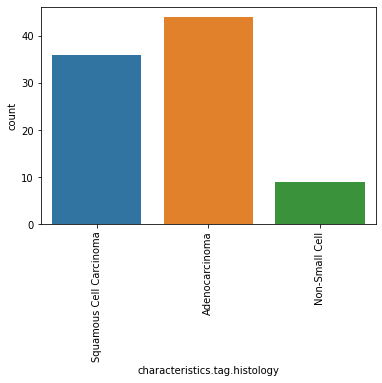

In [127]:
fig = sns.countplot(x=renamed['characteristics.tag.histology'])
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
plt.show()

In [167]:
s = renamed['characteristics.tag.histology']
su = s.unique()
colors = sns.light_palette('red', len(su))
lut = dict(zip(su, 'rgb'))
hist_color = s.map(lut)
hist_color = pd.Series(hist_color.values, index=renamed['characteristics.tag.histology'])

In [168]:
hist_color

characteristics.tag.histology
Squamous Cell Carcinoma    r
Adenocarcinoma             g
Non-Small Cell             b
Adenocarcinoma             g
Squamous Cell Carcinoma    r
                          ..
Adenocarcinoma             g
Squamous Cell Carcinoma    r
Squamous Cell Carcinoma    r
Non-Small Cell             b
Squamous Cell Carcinoma    r
Length: 89, dtype: object

In [169]:
test2 = test.reset_index()
test2['histology'] = renamed['characteristics.tag.histology'].values
test2 = test2.set_index('histology')


In [170]:
test2.T

histology,Squamous Cell Carcinoma,Adenocarcinoma,Non-Small Cell,Adenocarcinoma,Squamous Cell Carcinoma,Adenocarcinoma,Squamous Cell Carcinoma,Adenocarcinoma,Adenocarcinoma,Adenocarcinoma,...,Adenocarcinoma,Adenocarcinoma,Adenocarcinoma,Adenocarcinoma,Adenocarcinoma,Adenocarcinoma,Squamous Cell Carcinoma,Squamous Cell Carcinoma,Non-Small Cell,Squamous Cell Carcinoma
merck-BX537746_a_at,8.438459,8.114453,9.148630,8.185773,7.645143,8.108760,8.784605,7.798189,8.353256,8.831226,...,7.931126,9.022928,8.104895,7.712798,8.726615,7.850281,8.658315,7.393920,6.931018,8.401422
merck-NM_001901_at,11.972196,10.853984,12.660826,10.430675,10.792463,12.099779,9.156885,11.998764,12.488416,12.216505,...,11.774889,11.287679,10.937907,10.579917,11.935020,12.200319,11.697600,11.078211,10.612823,11.996207
merck2-NM_018615_a_at,4.976738,5.358033,5.762045,6.887234,6.241059,5.891850,4.982380,6.439245,6.277430,5.870426,...,6.341673,6.153500,5.938487,6.137524,7.262632,6.181192,6.852827,6.578593,5.545319,5.304426
merck-hCT1642439.3_at,2.236054,2.074821,2.455124,2.234124,2.087559,2.349066,2.797837,2.012790,2.190165,2.303660,...,2.433863,2.296725,1.937072,2.200822,2.664363,2.330104,2.236962,2.397698,2.145994,2.335807
merck-NR_002908_x_at,3.234880,2.372841,2.803546,2.438945,2.308809,2.696528,2.643353,2.647059,3.263814,2.899411,...,2.008020,3.307436,2.483943,2.503507,2.731600,3.217288,3.742196,3.702660,2.671930,2.046917
merck-hCT2267953_at,3.469075,4.270571,4.047404,3.668239,3.805180,4.151642,3.951189,3.620015,3.530118,4.231210,...,3.364831,3.662750,3.643701,3.784876,3.603153,3.991282,4.048737,3.975726,4.361563,4.049586
merck-RSE_00000228387_at,2.434678,2.650307,2.624297,2.438004,2.308244,2.523683,2.444407,2.388486,2.445364,2.575805,...,2.036563,2.229147,2.432922,2.704616,2.321905,2.185850,2.743018,2.486665,2.255568,2.389580
merck2-NM_145114_at,6.321765,5.423327,5.394842,6.463072,6.037466,6.194866,6.335625,6.402891,6.387445,6.415843,...,5.692671,5.577621,5.642019,5.956343,5.923748,6.045580,6.982375,5.914408,6.309975,6.158179
merck-NM_001030287_s_at,8.245600,7.795816,8.141739,6.971830,8.679486,8.322515,9.337660,8.123345,8.608280,9.451926,...,8.452862,8.378924,8.163868,7.989268,7.684531,7.595700,10.321368,9.421768,9.722756,11.463840
merck-BC043554_s_at,3.755041,4.858571,3.851604,4.027898,4.655249,4.837384,4.757974,4.282675,4.142284,4.269472,...,3.621448,3.760465,4.068980,3.884513,4.460930,4.076579,3.390358,3.858249,4.239753,4.590243


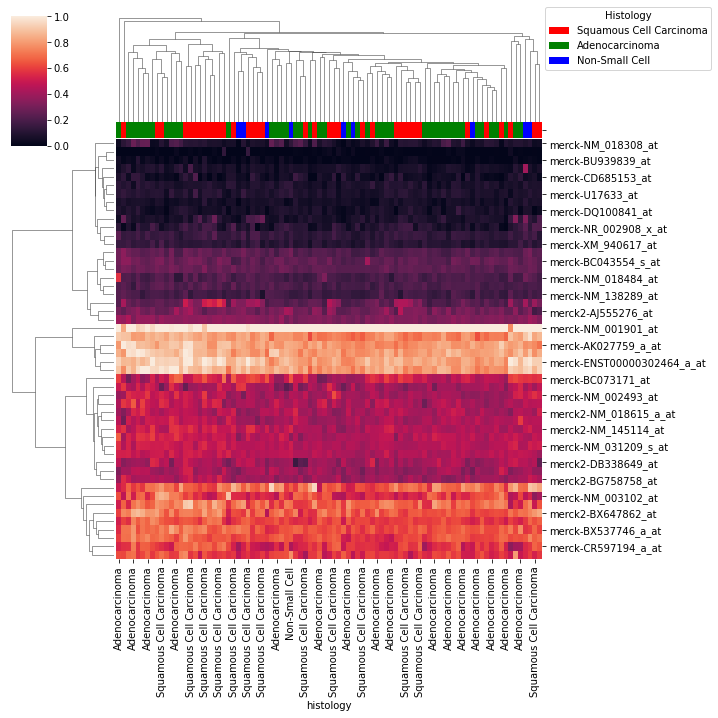

In [178]:
from matplotlib.patches import Patch

handles = [Patch(facecolor=lut[name]) for name in lut]

sns.clustermap(test2.T, standard_scale=1, col_colors=hist_color)
plt.legend(handles, lut, title='Histology', bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

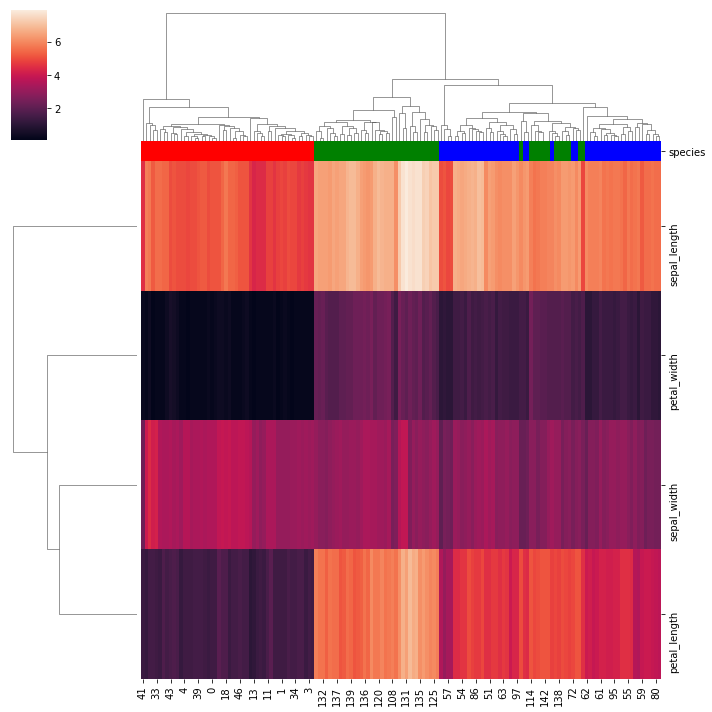

In [155]:
iris = sns.load_dataset("iris")
species = iris.pop("species")
lut = dict(zip(species.unique(), "rbg"))
row_colors = species.map(lut)
g = sns.clustermap(iris.T, col_colors=row_colors)

In [157]:
iris.T

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
sepal_length,5.1,4.9,4.7,4.6,5.0,5.4,4.6,5.0,4.4,4.9,...,6.7,6.9,5.8,6.8,6.7,6.7,6.3,6.5,6.2,5.9
sepal_width,3.5,3.0,3.2,3.1,3.6,3.9,3.4,3.4,2.9,3.1,...,3.1,3.1,2.7,3.2,3.3,3.0,2.5,3.0,3.4,3.0
petal_length,1.4,1.4,1.3,1.5,1.4,1.7,1.4,1.5,1.4,1.5,...,5.6,5.1,5.1,5.9,5.7,5.2,5.0,5.2,5.4,5.1
petal_width,0.2,0.2,0.2,0.2,0.2,0.4,0.3,0.2,0.2,0.1,...,2.4,2.3,1.9,2.3,2.5,2.3,1.9,2.0,2.3,1.8


In [158]:
row_colors

0      r
1      r
2      r
3      r
4      r
      ..
145    g
146    g
147    g
148    g
149    g
Name: species, Length: 150, dtype: object

In [162]:
hist_color

0     r
1     g
2     b
3     g
4     r
     ..
84    g
85    r
86    r
87    b
88    r
Name: characteristics.tag.histology, Length: 89, dtype: object

In [165]:
pd.Series(hist_color.values, index=renamed['characteristics.tag.histology'])

characteristics.tag.histology
Squamous Cell Carcinoma    r
Adenocarcinoma             g
Non-Small Cell             b
Adenocarcinoma             g
Squamous Cell Carcinoma    r
                          ..
Adenocarcinoma             g
Squamous Cell Carcinoma    r
Squamous Cell Carcinoma    r
Non-Small Cell             b
Squamous Cell Carcinoma    r
Length: 89, dtype: object